# Translation - AB Testing 

# Goal
* XYZ is a worldwide e-commerce site with localized versions of the site.
* A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country. She therefore went and talked to the international team in charge of Spain And LatAm to see if they had any ideas about why that was happening.
* Spain and LatAm country manager suggested that one reason could be translation. All Spanish - speaking countries had the same translation of the site which was written by a Spaniard. They agreed to try a test where each country would have its one translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican and so on. Obviously, nothing would change for users from Spain.
* After they run the test however, they are really surprised cause the test is negative. I.e., it appears that the non-localized translation was doing better!
* <span class="mark">**This project is to**</span>:
    * Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
    * Explain why that might be happening. Are the localized translations really worse?
    * If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

# Columns:
* `user_id` : the id of the user. Unique by user. Can be joined to user id in the other table. For each user, we just check whether conversion happens the first time they land on the site since the test started.
* `date` : when they came to the site for the first time since the test started
* `source` : marketing channel: Ads, SEO, Direct . Direct means everything except for ads and SEO. Such as directly typing site URL on the browser, downloading the app w/o coming from SEO or Ads, referral friend, etc.
* `device` : device used by the user. It can be mobile or web
* `browser_language` : in browser or app settings, the language chosen by the user. It can be EN, ES, Other (Other means any language except for English and Spanish) 
* `ads_channel` : if marketing channel is ads, this is the site where the ad was displayed. It can be: Google, Facebook, Bing, Yahoo ,Other. If the user didn't come via an ad, this field is NA
* `browser` : user browser. It can be: IE, Chrome, Android_App, FireFox, Iphone_App, Safari, Opera
* `conversion` : whether the user converted (1) or not (0). This is our label. A test is considered successful if it increases the proportion of users who convert.
* `test` : users are randomly split into test (1) and control (0). Test users see the new translation and control the old one. For Spain-based users, this is obviously always 0 since there is no change there.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

np.warnings.filterwarnings('ignore')

# 1.Load Dataset

In [3]:
test = pd.read_csv('test_table.csv',parse_dates=['date'])
user = pd.read_csv('user_table.csv')

In [4]:
test.head(5)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [5]:
user.head(5)

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [6]:
test['user_id'].nunique()

453321

In [7]:
user['user_id'].nunique()

452867

In [8]:
# merge two table on user_id
df = pd.merge(test,user, left_on='user_id',right_on='user_id',how='inner')

In [9]:
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,452867.0,499944.805166,288676.264784,1.0,249819.0,500019.0,749543.0,1000000.0
conversion,452867.0,0.049560,0.217034,0.0,0.0,0.0,0.0,1.0
test,452867.0,0.476462,0.499446,0.0,0.0,0.0,1.0,1.0
age,452867.0,27.130740,6.776678,18.0,22.0,26.0,31.0,70.0


* The average conversion rate is around 0.04956
* average users' age is around 27

In [11]:
df.describe(include='O').T

,count,unique,top,freq
source,452867,3,Ads,181693
device,452867,2,Web,251316
browser_language,452867,3,ES,377160
ads_channel,181693,5,Facebook,68358
browser,452867,7,Android_App,154977
sex,452867,2,M,264485
country,452867,17,Mexico,128484


In [12]:
df.isna().sum()

#271174 null values in ads_channel

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271174
browser                  0
conversion               0
test                     0
sex                      0
age                      0
country                  0
dtype: int64

In [13]:
df.ads_channel.value_counts(dropna=False)

NaN         271174
Facebook     68358
Google       68113
Yahoo        27409
Bing         13670
Other         4143
Name: ads_channel, dtype: int64

In [14]:
# fill null values with missing
df.fillna('Others',inplace=True)

In [15]:
df.isna().sum()

user_id             0
date                0
source              0
device              0
browser_language    0
ads_channel         0
browser             0
conversion          0
test                0
sex                 0
age                 0
country             0
dtype: int64

# 2. Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better

**Check if Spain is actually larger than the rest countries**

In [16]:
country_cvt = df.groupby('country')['conversion'].mean().to_frame('conversion').reset_index()

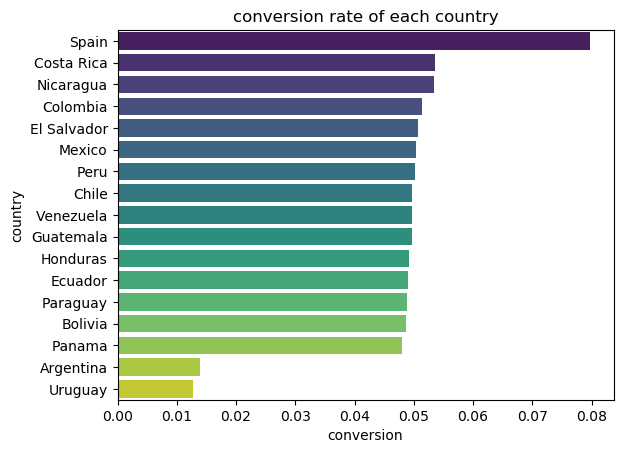

In [17]:
country_cvt = country_cvt.sort_values(ascending=False,by='conversion')
sns.barplot(data=country_cvt,y='country',x='conversion',palette='viridis')
plt.title('conversion rate of each country');

**Yes. Indeed Spain is doing better in general.**

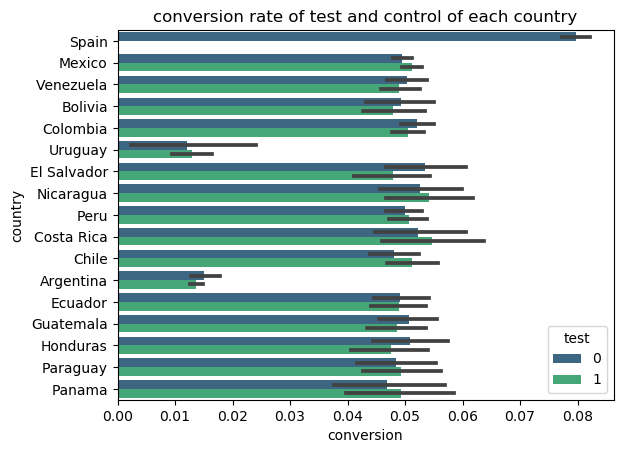

In [18]:
sns.barplot(data=df, 
            y='country', 
            x='conversion',
            hue='test',
            palette='viridis')
plt.title('conversion rate of test and control of each country');

In [19]:
#Check the average conversion rate of each group across all countries
test_avg = df[df['country']!='Spain']
test_val = test_avg[test_avg['test']==1]['conversion']
control_val = test_avg[test_avg['test']!=1]['conversion']

In [20]:
print('test:',test_val.mean())
print('control:',control_val.mean())
#test -> localized
#control -> non-localized

test: 0.043411161678422794
control: 0.04829179055749524


In [21]:
print(ttest_ind(test_val,control_val,equal_var=False))

Ttest_indResult(statistic=-7.353895203080277, pvalue=1.9289178577799033e-13)


**Conclusion**:
* Because p value is small, the difference between test and control groups is significant
* Statistics is negative -> test group is worse than the control group
    * So, <span class="mark">**the local-translation is worse**</span>

# 3. Why localization is worse? (Are they really worse?)

**Check randomization**\
Randomization is an important aspect of A/B testing because it helps to control for confounding variables and ensures that the groups being compared (the control group and the treatment group) are similar in all other aspects except for the variable being tested (the treatment).


In [23]:
tb = df[df['country']!='Spain']

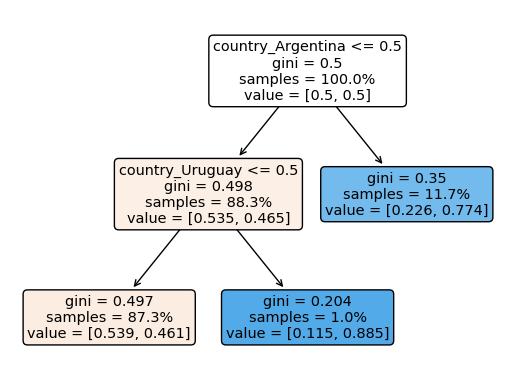

In [48]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn import tree

data = tb.drop(['user_id', 'date'], axis=1)

data_dummy = pd.get_dummies(data)
#don't drop any dummies

train_cols = data_dummy.drop(['test', 'conversion'], axis=1)

clf = DecisionTreeClassifier(class_weight='balanced',
                             min_impurity_decrease=0.001)
clf.fit(train_cols, data_dummy['test'])

tree.plot_tree(clf, filled=True, proportion=True, rounded=True,feature_names=train_cols.columns);

**Insights**:
* Yes, it can be observed that Argentina and Uruguay are present in the decision tree. This may indicate that the randomization process was not effective. A decision tree is a machine learning algorithm that attempts to divide the data into distinct groups based on certain features. The goal of the algorithm is to find a split that maximizes the difference in the outcome of interest between the groups created by the split.
* If the test and control groups were well randomized, there would be no clear splits in the tree, as the data would be evenly distributed among the groups and there would be no distinct patterns to base a split on. However, the presence of Argentina and Uruguay in the tree suggests that the randomization may not have been successful, and that there may be underlying factors that are influencing the results.

# 3. If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

We can create a function/algorithm that checks whether the dataset is well randomized by analyzing the splits in a decision tree created from the data. The function can be designed to utilize the tree's structure and determine if there are any clear patterns in the data that would indicate a lack of randomization. The algorithm can be trained and tested on the dataset and if it find that the splits are not random, it would conclude that the data is not well randomized, otherwise the data is well randomized.

In [53]:
def check_tree_split(data):
    data_dummy = pd.get_dummies(data)
    train_cols = data_dummy.drop(['test', 'conversion'], axis=1)
    clf = DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.001)
    clf.fit(train_cols, data_dummy['test'])
    
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    # Initialize the stack of nodes to visit
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            return True
        else:
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
    return False


In [55]:
data = tb.drop(['user_id', 'date'], axis=1)

if check_tree_split(data):
    print("The tree has splits and is not well randomized.")
else:
    print("The tree does not have any splits and is well randomized.")


The tree has splits and is not well randomized.
